In [1]:
#file for plotting maps 
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import geopandas as gpd
from shapely.geometry import shape
import numpy as np
from shapely import union_all
import h3
import pandas as pd
from shapely import Polygon
import matplotlib.patches as mpatches


In [2]:
world =gpd.read_file("../data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

In [3]:
with open('../final_results/task2/final_task2_v1_gemini_responses.json') as f:
    gemini_responses = json.load(f)

with open('../final_results/task2/final_task2_v1_gpt_responses.json') as f:
    gpt_responses = json.load(f)

with open('../data/meta_data/iucn_species_names.json') as f:
    species_names = json.load(f)

with open('../data/gt_data/iucn_res_5.json') as f:
    data = json.load(f)

In [4]:
species_ids = ["42888", "135104", "19284", "10717", "39579", "32944", "13270", "74831", "27123", "43339"]

In [5]:
def parse_geojson(response_text):
    # Step 1: Find the index of the first '[' and the last ']'
    start_index = response_text.find('{')
    end_index = response_text.rfind('}') + 1  # +1 to include the closing bracket

    # Step 2: Extract the substring containing just the list
    cleaned_response = response_text[start_index:end_index]

    # Attempt to parse the model's output
    outline = json.loads(cleaned_response)
    # Step 3: Parse the cleaned response into a dictionary

    # Step 4: Extract the geometries from the GeoJSON features
    geometries = [shape(feature["geometry"]) for feature in outline["features"]]

    # Step 5: Convert the geometries into a GeoDataFrame
    geojson_gdf = gpd.GeoDataFrame(geometry=geometries)

    return geojson_gdf


In [6]:
def get_square_bounds(gdfs, padding=0):
    # Initialize min/max values for x and y
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')

    # Loop through all GeoDataFrames and calculate the bounding box
    for gdf in gdfs:
        bounds = gdf.total_bounds  # Returns (minx, miny, maxx, maxy)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])

    # Calculate the ranges
    x_range = max_x - min_x
    y_range = max_y - min_y

    # Determine the larger range to ensure the plot is square
    max_range = max(x_range, y_range)

    # Return square bounds with padding
    return (min_x - padding, min_x + max_range + padding, 
            min_y - padding, min_y + max_range + padding)


In [7]:
def get_h3_cell(lat, lng):
    return h3.geo_to_h3(lat, lng, 5)
iucn_dfs = []
for taxa in species_ids:
    data_df = pd.DataFrame(np.array(data['locs'])[data['taxa_presence'][str(taxa)]], columns=['lng','lat'])
    # Add H3 cell column
    data_df['h3index'] = data_df.apply(lambda row: get_h3_cell(row['lat'], row['lng']), axis=1)
    data_df['geometry'] = data_df.h3index.map(lambda cell: Polygon(h3.h3_to_geo_boundary(cell, True)))
    iucn_dfs.append(data_df)
def unify_shape(cells):
    # Perform union of geometries in the cells
    union_geometry = union_all(cells.geometry)
    # Intersect with the world geometry to ensure it's valid for display
    intersected_geometry = union_geometry.intersection(union_all(world.geometry))
    # Create a GeoDataFrame from the intersected geometry
    return gpd.GeoDataFrame(geometry=[intersected_geometry], crs="EPSG:4326")

In [8]:
def get_square_bounds_fallback(plot_df, padding=10):
    # Assuming plot_df has valid geometry data to calculate bounds
    bounds = plot_df.total_bounds  # (minx, miny, maxx, maxy)
    min_x, min_y, max_x, max_y = bounds
    
    # Calculate ranges
    x_range = max_x - min_x
    y_range = max_y - min_y

    # Determine the larger range to make the plot square
    max_range = max(x_range, y_range)

    # Return square bounds with padding
    return (min_x - padding, min_x + max_range + padding, 
            min_y - padding, min_y + max_range + padding)

not possible to print id  74831
Generating bounds based on fallback data (plot_df)


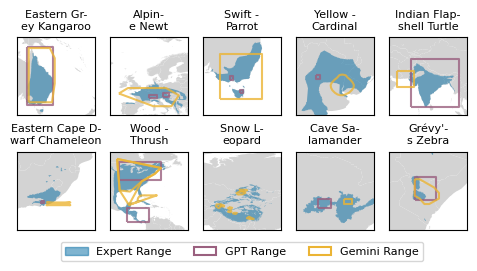

In [9]:

cmap = plt.cm.RdYlGn  # Use the RdYlGn colormap

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(2, 5, figsize=(12.2*cm, 6.5*cm))

padding=5

for i,ax in enumerate(axs.flatten()):
    world.plot(ax=ax,color="lightgray")
    # Remove ticks and axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    plot_df = unify_shape(iucn_dfs[i])
    plot_df.plot(ax=ax, color="#006BA2", alpha=0.5)

    species_id = species_ids[i]
    gpt_response = gpt_responses[species_id]["response"]
    gemini_response = gemini_responses[species_id]["response"]

        # Helper function to check if the GeoDataFrame is plottable
    def is_plottable(gdf):
        return not gdf.empty 

    # Plot only if the GeoDataFrame is plottable
    try: 
        gpt_gdf = parse_geojson(gpt_response)
        gpt_gdf.plot(ax=ax, edgecolor='#9A607F', facecolor='none', linewidth=1.5, alpha=0.8)  # Customize color or style as needed
    except: 
        print("not possible to print id ", species_id )
        gpt_gdf = None  # Mark as failed
    try: 
        gemini_gdf = parse_geojson(gemini_response)
        gemini_gdf.plot(ax=ax, edgecolor='#EBB434', facecolor='none', linewidth=1.5, alpha=0.8)  # Customize color or style as needed
    except: 
        print("not possible to print id ", species_id )
        gemini_gdf = None  # Mark as failed


    # Fallback to bounds generation based on plot_df if GeoDataFrames are not plottable
    if gpt_gdf is None or gemini_gdf is None:
        print("Generating bounds based on fallback data (plot_df)")
        min_x, max_x, min_y, max_y = get_square_bounds_fallback(plot_df, padding=padding)
    else:
        # Calculate square bounds for both GeoDataFrames if they are valid
        min_x, max_x, min_y, max_y = get_square_bounds([gpt_gdf, gemini_gdf], padding=padding)


    # Set the axis limits to ensure the plot is square
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    # Optionally, adjust aspect ratio for the square plot
    ax.set_aspect('equal')

    max_title_length = 20
    # Get the common name and truncate if necessary
    common_name = species_names[species_id]["common_name"]
    # Split the common name into two lines
    mid_point = len(common_name) // 2
    common_name = common_name[:mid_point] + "-\n" + common_name[mid_point:]

    ax.set_title(common_name, fontsize=8, loc='center')

# Create custom patches for the legend
expert_patch = mpatches.Patch(color="#006BA2", label="Expert Range", alpha=0.5)
gpt_patch = mpatches.Patch(edgecolor='#9A607F', facecolor='none', label="GPT Range", linewidth=1.5)
gemini_patch = mpatches.Patch(edgecolor='#EBB434', facecolor='none', label="Gemini Range", linewidth=1.5)
plt.figlegend(handles=[expert_patch, gpt_patch, gemini_patch], loc='lower center', ncol=3, fontsize=8, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.savefig('plots/task2_comparison.png', format='png', dpi=1200, bbox_inches='tight')



In [12]:
#calculate mean f1 score:
gpt_metrics = pd.read_csv("task2/final_task2_v1_gpt_responses.csv")
gpt_metrics.fillna(0).describe()

,F1
count,10.000000
mean,0.246584
std,0.252324
min,0.000000
25%,0.025865
50%,0.148536
75%,0.476393
max,0.668152


In [13]:
gemini_metrics = pd.read_csv("task2/final_task2_v1_gemini_responses.csv")
gemini_metrics.fillna(0).describe()

,F1
count,10.000000
mean,0.322064
std,0.282476
min,0.000000
25%,0.076938
50%,0.289139
75%,0.588077
max,0.679469
